The objective is to predict the success of telemarketing calls for selling bank long-term deposits. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
import pandas_profiling
import seaborn as sns
sns.set()

# Loading data and overview

In [2]:
data=pd.read_csv('bank-full.csv', sep=";")
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [3]:
print("Dataset consists of {} observations and has {} columns".format(*data.shape))

Dataset consists of 45211 observations and has 17 columns


In [4]:
# number of unique values:
data.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

## Features and target variables

1. age: Continuous feature
2. job: type of job - categorical
3. marital: marital status - categorical
4. education: education level - categorical
5. default: has credit in default? - categorical
6. housing: has housing loan? - categorical
7. loan: has personal loan? - categorical
8. balance: balance in account - continuous
9. contact: contact commmunication type
10. month: last contact month of year - categorical
11. day: last contact day of the month - categorical
12. duration: last contact duration in seconds - continuous
13. campaign: number of contacts performed during this campaign and for this client - continuous
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (-1 tells us the person has not been contacted or contact period is beyond 900 days) - continuous
15. previous: number of times the client has been contacted before for the last campaign to subscribe term deposit - continuous
16. poutcome: outcome of the previous campaign - categorical
17. Target: Tell us has the client subscribed a term deposit - binary label

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There is no null values in the dataset but it does not mean we do not have missing data. There are many unknowns in job, education, poutcome, and contact columns

In [6]:
f=lambda x: print(f"Number of `unknows` in {x}: {sum(data[x]=='unknown')}, {sum(data[x]=='unknown')/data.shape[0]*100:.2f}%")
for item in ['job', 'education', 'poutcome', 'contact']:
    f(item)

Number of `unknows` in job: 288, 0.64%
Number of `unknows` in education: 1857, 4.11%
Number of `unknows` in poutcome: 36959, 81.75%
Number of `unknows` in contact: 13020, 28.80%


# Exploratory data quality report

Pandas profile provides a nice report of the dataset quality which includes name, range of values, central values, number of missing values , and number of zeros. It also provides histogram for continuous variables and bar chart for categorical variables. Additionally it provides bivariate analysis between any pair of variables.

In [7]:
data.profile_report()

## Univariate analysis:

In [8]:
# data describe gives mean/median, std, quurtiles, and range of numeric variables
data.describe().T

count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   

               max  
age           95.0  
balance   102127.0  
day           31.0  
duration    4918.0  
campaign      63.0  
pdays        871.0  
previous     275.0

Insights:
* age is skewed and may have outlier
* balance is right-skewed and has outlier
* duratyion is right-skewed and has outlier

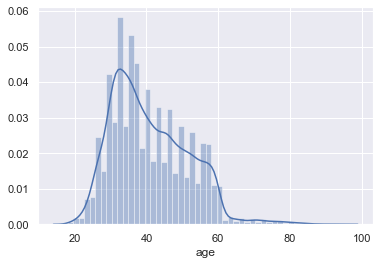

In [9]:
# First, we can check the distribution and histograms of the continuous variables:
# 1. age:
sns.distplot(data["age"]);

In [10]:
print(f"average age: {data['age'].mean():.2f}, median age: {data['age'].median()}")

average age: 40.94, median age: 39.0


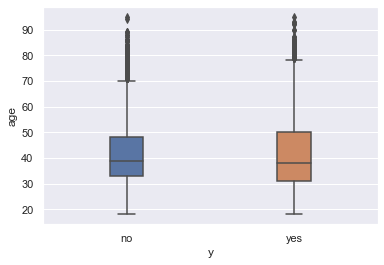

In [11]:
sns.boxplot(data["y"],data["age"], width=0.2);

Comment:<br>
Age has some outliers. We could remove the outliers but we are going to loss some samples, or we can convert age to categorical variable. For now I leave it as is.

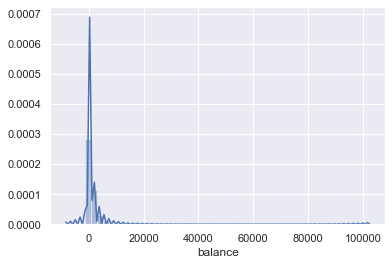

In [12]:
# 2. balance:
sns.distplot(data["balance"]);
# this variable can be converted to categorical variable in 6 buckets:
# -1:negative, 0:zero, 1:zero to 500, 2:500 to 2500, 3: 2500 to 5000, and 4: more than 5000

Comment:<br>Balance column has many zero values, is skewed, and has outliers. Therefore, it will be discretized to 6 bins and is converted to categorical variable

In [13]:
data.loc[data["balance"]<0,"balance"]=-1
data.loc[(data["balance"]>0) & (data["balance"]<=500),"balance"]=1
data.loc[(data["balance"]>500) & (data["balance"]<=2500),"balance"]=2
data.loc[(data["balance"]>2500) & (data["balance"]<=5000),"balance"]=3
data.loc[data["balance"]>5000,"balance"]=4

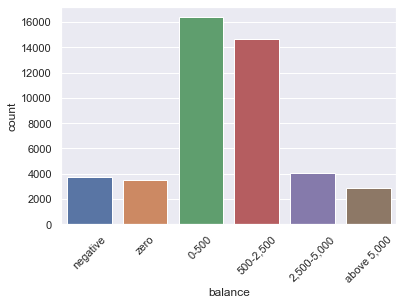

In [14]:
viz=sns.countplot(data["balance"])
plt.xticks(ticks=viz.get_xticks(), 
           labels=['negative', 'zero', '0-500','500-2,500', '2,500-5,000','above 5,000'], rotation=45)
plt.show()

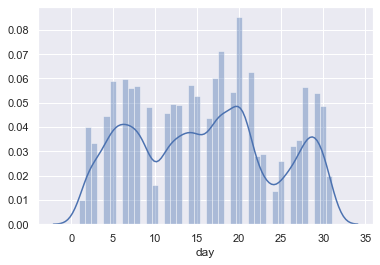

In [15]:
# 3. Day:
sns.distplot(data["day"]); 
# this can be also simplified by converting day to categorical variable such as weeks within a month 

In [16]:
data.loc[data["day"]<8, "day"]=1
data.loc[(data["day"]>=8) & (data["day"]<15), "day"]=2
data.loc[(data["day"]>=15) & (data["day"]<22), "day"]=3
data.loc[data["day"]>=22, "day"]=4

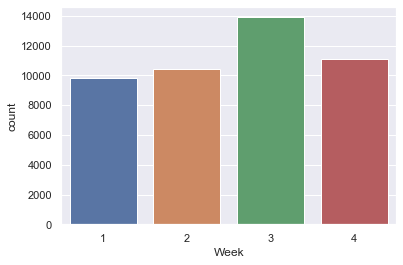

In [17]:
sns.countplot(data["day"])
plt.xlabel("Week");

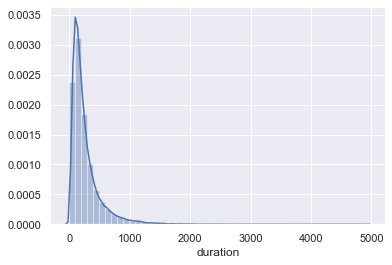

In [18]:
#4. duration:
sns.distplot(data['duration']);

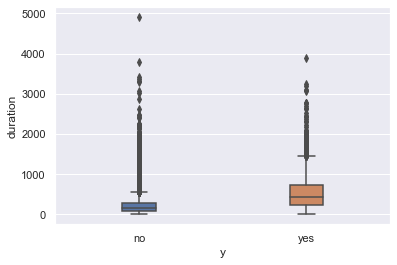

In [19]:
sns.boxplot(data["y"], data['duration'], width=0.2);

Comment:<br> Duration is also right-skewed and has many outliers we can convert it to categorical data with four buckets:<br> less than 100 seconds, between 100 and 200 seconds, between 200 and 300 seconds, and more than 300 seconds 

In [20]:
data.loc[data["duration"]<=100, "duration"]=1
data.loc[(data["duration"]>100) & (data["duration"]<=200), "duration"]=2
data.loc[(data["duration"]>200) & (data["duration"]<=300), "duration"]=3
data.loc[data["duration"]>300, "duration"]=4

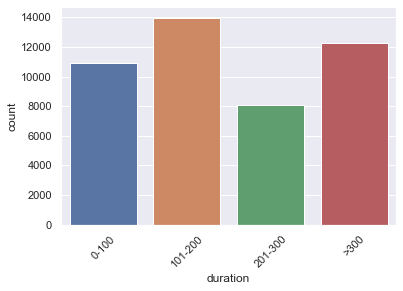

In [21]:
viz=sns.countplot(data["duration"])
plt.xticks(ticks=viz.get_xticks(), labels=['0-100','101-200','201-300','>300'], rotation=45);

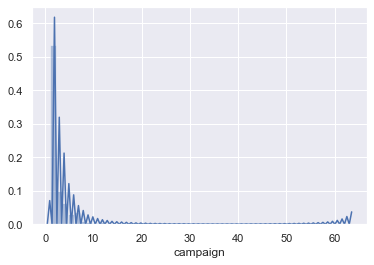

In [22]:
#5. Campaign
sns.distplot(data["campaign"]);

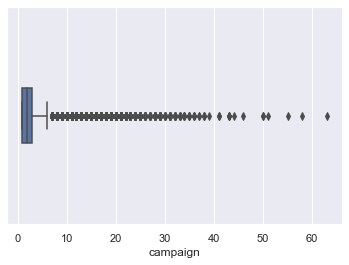

In [23]:
sns.boxplot(data["campaign"], width=0.25);

In [24]:
data["campaign"].value_counts(normalize=True)*100

1     38.804716
2     27.659198
3     12.211630
4      7.790140
5      3.901705
6      2.855500
7      1.625711
8      1.194400
9      0.723275
10     0.588352
11     0.444582
12     0.342837
13     0.294176
14     0.205702
15     0.185795
16     0.174736
17     0.152618
18     0.112804
19     0.097321
20     0.095110
21     0.077415
22     0.050873
23     0.048661
25     0.048661
24     0.044237
28     0.035390
29     0.035390
26     0.028754
31     0.026542
27     0.022119
32     0.019907
30     0.017695
33     0.013271
34     0.011059
36     0.008847
35     0.008847
43     0.006636
38     0.006636
41     0.004424
50     0.004424
37     0.004424
51     0.002212
55     0.002212
46     0.002212
58     0.002212
44     0.002212
39     0.002212
63     0.002212
Name: campaign, dtype: float64

Comment:<br> the number of contacts is alse very skewed and has many outliers. Thus, it sould be converted to categorical variable with three categories:<br> contact ones, contact twice and contact 3 times or more

In [25]:
data.loc[data["campaign"]>=3, "campaign"]=3

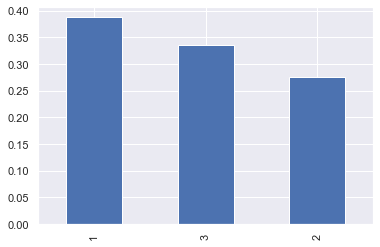

In [26]:
data["campaign"].value_counts(normalize=True).plot(kind='bar');

In [27]:
#6. pdays
print(f"percentage of the clients that were not contacted: {round(sum(data['pdays']==-1)/len(data)*100,2)}")

percentage of the clients that were not contacted: 81.74


In [28]:
# since 82% of the pdays is -1 we are missing many data in this column so it is better to drop it
data.drop('pdays', axis=1, inplace=True)

In [29]:
#7. Previous
data["previous"].value_counts(normalize=True)*100

0      81.736745
1       6.131251
2       4.658158
3       2.525934
4       1.579262
5       1.015240
6       0.612683
7       0.453429
8       0.285329
9       0.203490
10      0.148194
11      0.143770
12      0.097321
13      0.084050
15      0.044237
14      0.042025
17      0.033178
16      0.028754
19      0.024330
23      0.017695
20      0.017695
22      0.013271
18      0.013271
24      0.011059
27      0.011059
29      0.008847
25      0.008847
21      0.008847
30      0.006636
28      0.004424
26      0.004424
37      0.004424
38      0.004424
55      0.002212
40      0.002212
35      0.002212
58      0.002212
51      0.002212
41      0.002212
32      0.002212
275     0.002212
Name: previous, dtype: float64

Comment:<br>82% of the values in this column is zero so it is better to convert it to two categories: zero and non-zero contacts

In [30]:
data["previous"]=data["previous"].apply(lambda x: 1 if x>0 else 0)
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no        2     yes   no   
1   44    technician   single  secondary      no        1     yes   no   
2   33  entrepreneur  married  secondary      no        1     yes  yes   
3   47   blue-collar  married    unknown      no        2     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  previous poutcome   y  
0  unknown    1   may         3         1         0  unknown  no  
1  unknown    1   may         2         1         0  unknown  no  
2  unknown    1   may         1         1         0  unknown  no  
3  unknown    1   may         1         1         0  unknown  no  
4  unknown    1   may         2         1         0  unknown  no

### Summary:
Beside age all other continuous variables were converted to categorical variables to fix issues related to skewness and outliers

# Bi-variate and univariate analysis for categorical variables

blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
unknown          0.006370
Name: job, dtype: float64


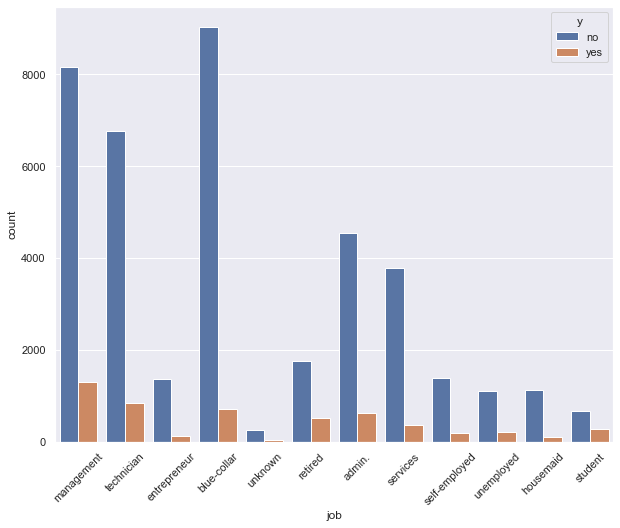

In [31]:
# second, the distribution of the categorical data:
#1. job
print(data["job"].value_counts(normalize=True))
plt.figure(figsize=(10,8))
sns.countplot(data["job"], hue=data["y"])
plt.xticks(rotation=45);

In [32]:
pd.crosstab(data["y"], data["job"], normalize="columns") # bi-variate analysis between job and target

job    admin.  blue-collar  entrepreneur  housemaid  management   retired  \
y                                                                           
no   0.877973      0.92725      0.917283   0.912097    0.862444  0.772085   
yes  0.122027      0.07275      0.082717   0.087903    0.137556  0.227915   

job  self-employed  services  student  technician  unemployed   unknown  
y                                                                        
no        0.881571   0.91117  0.71322     0.88943    0.844973  0.881944  
yes       0.118429   0.08883  0.28678     0.11057    0.155027  0.118056

Comment:<br>The distribution of yes/no is fairly similar among different jobs except retired and students that get more yes compared to other categories

married     0.601933
single      0.282896
divorced    0.115171
Name: marital, dtype: float64


marital  divorced   married    single
y                                    
no       0.880545  0.898765  0.850508
yes      0.119455  0.101235  0.149492

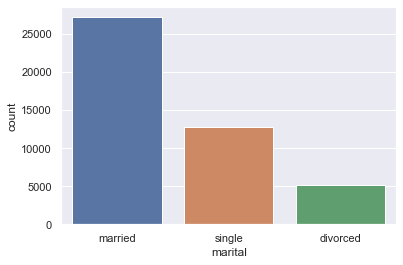

In [33]:
#2. marital status:
print(data["marital"].value_counts(normalize=True))
display(pd.crosstab(data["y"], data["marital"], normalize="columns")) # bi-variate analysis between marital and target
sns.countplot(data["marital"]);

Comment:<br>the subscription rate is similar among different groups 

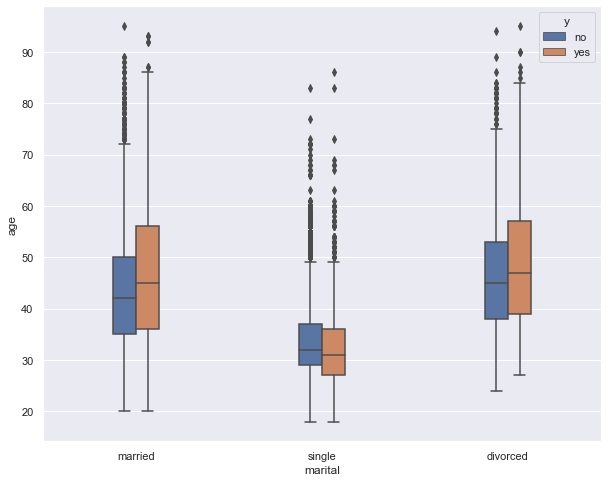

In [34]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data, x='marital', y='age', hue='y', width=0.25);

In [35]:
#3. Education:
print(data["education"].value_counts(normalize=True))
display(pd.crosstab(data["y"], data["education"], normalize="columns"))

secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: education, dtype: float64


education   primary  secondary  tertiary   unknown
y                                                 
no         0.913735   0.894406  0.849936  0.864297
yes        0.086265   0.105594  0.150064  0.135703

Comment:<br> the distribution of sunbscribers in theses four categories is similar we can say education does not have much relationship with subscription. We can potentially drop this column to get simpler model and get rid of unknows in this columns without lossing the information since this column has 4% unknowns

In [36]:
#4. default:
display(pd.crosstab(data["y"], data["default"], normalize="columns"))
data["default"].value_counts()

default        no       yes
y                          
no       0.882039  0.936196
yes      0.117961  0.063804

no     44396
yes      815
Name: default, dtype: int64

Comment:<br>the distribution of sunbscribers in theses two categories is very similar we can say default does not have much effect on subscription. We can drop this column to get simpler model

In [37]:
data.drop('default', axis=1, inplace=True)

In [38]:
#5. housing:
print(data["housing"].value_counts(normalize=True))
pd.crosstab(data["y"], data["housing"], normalize="columns")

yes    0.555838
no     0.444162
Name: housing, dtype: float64


housing        no    yes
y                       
no       0.832976  0.923
yes      0.167024  0.077

Comment:<br>customers with no housing loan are slightly more likely to subscribe

In [39]:
#6. loan:
data["loan"].value_counts(normalize=True)
display(pd.crosstab(data["y"],data["loan"], normalize='columns'))

loan        no       yes
y                       
no    0.873443  0.933186
yes   0.126557  0.066814

Comment:<br>
Customers without loan has slightly better chance to subscribe but the diference might not be significant

In [40]:
#7. month:
print(data["month"].value_counts(normalize=True))
display(pd.crosstab(data["y"], data["month"], normalize="columns"))

may    0.304483
jul    0.152507
aug    0.138174
jun    0.118135
nov    0.087810
apr    0.064851
feb    0.058592
jan    0.031032
oct    0.016323
sep    0.012807
mar    0.010551
dec    0.004733
Name: month, dtype: float64


month       apr       aug      dec       feb       jan       jul       jun  \
y                                                                            
no     0.803206  0.889867  0.53271  0.833522  0.898788  0.909065  0.897772   
yes    0.196794  0.110133  0.46729  0.166478  0.101212  0.090935  0.102228   

month       mar       may       nov       oct       sep  
y                                                        
no     0.480084  0.932805  0.898489  0.562331  0.535406  
yes    0.519916  0.067195  0.101511  0.437669  0.464594

Comment:<br>most of the customers were contacted during summer. The hit ratio is higher in Dec, Mar, Oct, and Sep

In [41]:
#8. poutcome:
data["poutcome"].value_counts(normalize=True)

unknown    0.817478
failure    0.108403
other      0.040698
success    0.033421
Name: poutcome, dtype: float64

Comment:<br>82% of the poutcomes are unknown which is missing data since this value is very high I decide to drop the poutcome column. Additionally the contact method is not important so I drop it too

In [42]:
data.drop(['poutcome', 'contact'], axis=1, inplace=True)

In [43]:
data.head()

age           job  marital  education  balance housing loan  day month  \
0   58    management  married   tertiary        2     yes   no    1   may   
1   44    technician   single  secondary        1     yes   no    1   may   
2   33  entrepreneur  married  secondary        1     yes  yes    1   may   
3   47   blue-collar  married    unknown        2     yes   no    1   may   
4   33       unknown   single    unknown        1      no   no    1   may   

   duration  campaign  previous   y  
0         3         1         0  no  
1         2         1         0  no  
2         1         1         0  no  
3         1         1         0  no  
4         2         1         0  no

In [44]:
print(f'Percentage of unknown values in education column: {sum(data["education"]=="unknown")/len(data)*100:.2f}%')
print(f'Percentage of unknown values in job column: {sum(data["job"]=="unknown")/len(data)*100:.2f}%')

Percentage of unknown values in education column: 4.11%
Percentage of unknown values in job column: 0.64%


Based on the percentage of the missing values in education column and as the hit ratio among customers with diffrent level of education is almost the same I decided to drop this column. Removing the samples with unknown job only loses 0.6% of the data which is okay so we can drop those rows

In [45]:
data.drop("education", axis=1, inplace=True)

In [46]:
data.head()

age           job  marital  balance housing loan  day month  duration  \
0   58    management  married        2     yes   no    1   may         3   
1   44    technician   single        1     yes   no    1   may         2   
2   33  entrepreneur  married        1     yes  yes    1   may         1   
3   47   blue-collar  married        2     yes   no    1   may         1   
4   33       unknown   single        1      no   no    1   may         2   

   campaign  previous   y  
0         1         0  no  
1         1         0  no  
2         1         0  no  
3         1         0  no  
4         1         0  no

In [47]:
data["job"]=data["job"].replace("unknown", np.nan)

In [48]:
data.dropna(subset=["job"], inplace=True)

In [49]:
data.head(10)

age           job   marital  balance housing loan  day month  duration  \
0    58    management   married        2     yes   no    1   may         3   
1    44    technician    single        1     yes   no    1   may         2   
2    33  entrepreneur   married        1     yes  yes    1   may         1   
3    47   blue-collar   married        2     yes   no    1   may         1   
5    35    management   married        1     yes   no    1   may         2   
6    28    management    single        1     yes  yes    1   may         3   
7    42  entrepreneur  divorced        1     yes   no    1   may         4   
8    58       retired   married        1     yes   no    1   may         1   
9    43    technician    single        2     yes   no    1   may         1   
10   41        admin.  divorced        1     yes   no    1   may         3   

    campaign  previous   y  
0          1         0  no  
1          1         0  no  
2          1         0  no  
3          1         0  no  
5          1         0  no  
6          1         0  no  
7          1         0  no  
8          1         0  no  
9          1         0  no  
10         1         0  no

In [50]:
#9. target variable:
data["y"].value_counts(normalize=True)*100

no     88.302206
yes    11.697794
Name: y, dtype: float64

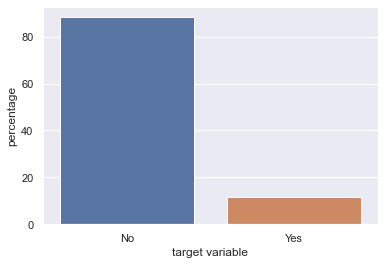

In [51]:
viz=sns.barplot([0,1],data["y"].value_counts(normalize=True)*100)
plt.xlabel("target variable")
plt.ylabel("percentage")
plt.xticks(ticks=viz.get_xticks(), labels=["No", "Yes"]);

Comment:<br>
Target variable is imbalance meaning it has much more `no` compared to `yes`. This imbalance may afect the performance of the classifiers at default threshold for binary classification.

# Preparing data for analytics

In [52]:
### converting the data types for binary and categories:
for col in ["job", "marital", "balance", "day","month", "duration","campaign"]:
    data[col]=data[col].astype('category')

In [53]:
data[["housing","loan","y"]]=data[["housing","loan","y"]].replace({"no":0, "yes":1})

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44923 entries, 0 to 45210
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       44923 non-null  int64   
 1   job       44923 non-null  category
 2   marital   44923 non-null  category
 3   balance   44923 non-null  category
 4   housing   44923 non-null  int64   
 5   loan      44923 non-null  int64   
 6   day       44923 non-null  category
 7   month     44923 non-null  category
 8   duration  44923 non-null  category
 9   campaign  44923 non-null  category
 10  previous  44923 non-null  int64   
 11  y         44923 non-null  int64   
dtypes: category(7), int64(5)
memory usage: 2.4 MB


In [55]:
clean_data=pd.get_dummies(data, drop_first=True)

In [56]:
clean_data.head(10)

age  housing  loan  previous  y  job_blue-collar  job_entrepreneur  \
0    58        1     0         0  0                0                 0   
1    44        1     0         0  0                0                 0   
2    33        1     1         0  0                0                 1   
3    47        1     0         0  0                1                 0   
5    35        1     0         0  0                0                 0   
6    28        1     1         0  0                0                 0   
7    42        1     0         0  0                0                 1   
8    58        1     0         0  0                0                 0   
9    43        1     0         0  0                0                 0   
10   41        1     0         0  0                0                 0   

    job_housemaid  job_management  job_retired  ...  month_mar  month_may  \
0               0               1            0  ...          0          1   
1               0               0            0  ...          0          1   
2               0               0            0  ...          0          1   
3               0               0            0  ...          0          1   
5               0               1            0  ...          0          1   
6               0               1            0  ...          0          1   
7               0               0            0  ...          0          1   
8               0               0            1  ...          0          1   
9               0               0            0  ...          0          1   
10              0               0            0  ...          0          1   

    month_nov  month_oct  month_sep  duration_2  duration_3  duration_4  \
0           0          0          0           0           1           0   
1           0          0          0           1           0           0   
2           0          0          0           0           0           0   
3           0          0          0           0           0           0   
5           0          0          0           1           0           0   
6           0          0          0           0           1           0   
7           0          0          0           0           0           1   
8           0          0          0           0           0           0   
9           0          0          0           0           0           0   
10          0          0          0           0           1           0   

    campaign_2  campaign_3  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
5            0           0  
6            0           0  
7            0           0  
8            0           0  
9            0           0  
10           0           0  

[10 rows x 41 columns]

In [57]:
# making feature matrix and target vector:
X=clean_data.drop("y", axis=1)
y=clean_data["y"]

In [58]:
# splitting the data to training and test sets:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [59]:
# distribution of the target in original set, training set and test set:
print("smaple size in original dataset:", clean_data.shape[0])
print(f"smaple size in training dataset: {y_train.shape[0]} which is {y_train.shape[0]/clean_data.shape[0]*100:.2f}%")
print(f"smaple size in test dataset: {y_test.shape[0]} which is {y_test.shape[0]/clean_data.shape[0]*100:.2f}%")
print("="*100)
print(f"distribution in original dataset: {sum(y==1)/len(y)*100:.2f}% yes and {sum(y==0)/len(y)*100:.2f}% no")
print(f"distribution in training dataset: {sum(y_train==1)/len(y_train)*100:.2f}% yes and {sum(y_train==0)/len(y_train)*100:.2f}% no")
print(f"distribution in test dataset:     {sum(y_test==1)/len(y_test)*100:.2f}% yes and {sum(y_test==0)/len(y_test)*100:.2f}% no")

smaple size in original dataset: 44923
smaple size in training dataset: 31446 which is 70.00%
smaple size in test dataset: 13477 which is 30.00%
distribution in original dataset: 11.70% yes and 88.30% no
distribution in training dataset: 11.65% yes and 88.35% no
distribution in test dataset:     11.82% yes and 88.18% no


Comment:<br>the distributions of the labels are similar in all three datasets

# Create the machine learning models

To compare the performance of diferent classifiers, first, a dataframe is created to store scores for classifiers.<br>
Eight classifiers will be considered:<br>
Logistic regression, Full decition tree, Pruned decision tree, Naive Bayes, Bagging, Random Forest, Adaptive boosting, and Gradient boosting

In [60]:
models=[
    'model_LR',
    'model_tree',
    'model_tree_pruned',
    'model_NB',
    'model_bagging',
    'model_RF',
    'model_adaboost',
    'model_GB'
]
classifiers=pd.DataFrame(data=np.c_[models,np.zeros((len(models),5))],
                         columns=["estimator","accuracy","recall","precision","F1_score","ROC_AUC"])

classifiers.head()

estimator accuracy recall precision F1_score ROC_AUC
0           model_LR      0.0    0.0       0.0      0.0     0.0
1         model_tree      0.0    0.0       0.0      0.0     0.0
2  model_tree_pruned      0.0    0.0       0.0      0.0     0.0
3           model_NB      0.0    0.0       0.0      0.0     0.0
4      model_bagging      0.0    0.0       0.0      0.0     0.0

In [61]:
# some functions to create performance report for different classifiers
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_roc_curve

def make_cm(model, x_observed, y_observed, model_type, threshold=None):
    if threshold:
        y_predict=predict_label(model, x_observed, threshold)
    else:
        y_predict=model.predict(x_observed)
    cm=confusion_matrix(y_observed, y_predict)
    sns.heatmap(cm, annot=True, cbar=False, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.title("Confusion Matrix - "+model_type)
    plt.show()
    
def report_scores(model, x_observed, y_observed, model_type, threshold=None, verbos=True):
    if threshold:
        y_predict=predict_label(model, x_observed, threshold)
    else:
        y_predict=model.predict(x_observed)
    y_predict_prob=model.predict_proba(x_observed)[:,1]
    scores=list(map(lambda x: round(x,3), 
            [accuracy_score(y_observed, y_predict), 
            recall_score(y_observed, y_predict), 
            precision_score(y_observed, y_predict),
            f1_score(y_observed, y_predict),
            roc_auc_score(y_observed, y_predict_prob)]))
    if verbos:
        print("="*60)
        print(model_type.rjust(40))
        print("="*60)
        print(f"Accuracy score:  {scores[0]}")
        print(f"Recall score:    {scores[1]}")
        print(f"Precision score: {scores[2]}")    
        print(f"F1 score:        {scores[3]}")
        print(f"ROC_AUC score:   {scores[4]}")
    return scores
    
def plot_roc(model, x, y, ax=None):
    if not ax:
        f,ax=plt.subplots(figsize=(10,8))    
    plot_roc_curve(model,x,y,ax=ax)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot([0,1],[0,1],'k--')
    plt.show()
    
def predict_label(model, x, threshold=0.5):
    y_prob=model.predict_proba(x)    
    return (y_prob[:,1]>threshold).astype(int)

### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
model_LR=LogisticRegression(max_iter=1000)
model_LR.fit(x_train, y_train)
print("Training score: %.3f" %model_LR.score(x_train,y_train))
print("Test score: %.3f"  %model_LR.score(x_test, y_test))

Training score: 0.893
Test score: 0.890


In [63]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_LR"].index, 1:]= \
    report_scores(model_LR, x_test, y_test, "Logistic Regression")

                     Logistic Regression
Accuracy score:  0.89
Recall score:    0.21
Precision score: 0.596
F1 score:        0.31
ROC_AUC score:   0.863


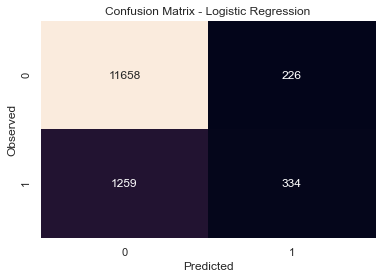

In [64]:
make_cm(model_LR, x_test, y_test, "Logistic Regression")

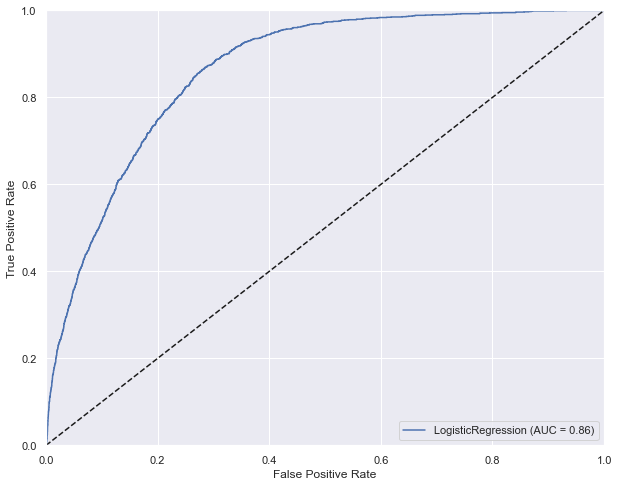

In [65]:
plot_roc(model_LR, x_test, y_test)

In [66]:
pi=pd.DataFrame()
pi["Col"]=x_train.columns
pi["Coeff"]=abs(model_LR.coef_[0])
pi.sort_values(by='Coeff',ascending=False).head(12)

Col     Coeff
37  duration_4  3.687202
36  duration_3  2.336576
30   month_mar  1.794244
35  duration_2  1.498836
27   month_jan  1.209173
3     previous  0.983977
33   month_oct  0.963634
31   month_may  0.947644
34   month_sep  0.836561
19   balance_3  0.777851
1      housing  0.692871
25   month_dec  0.587144

Comments on Logestic Regression model:<br>
* ROC_AUC score is 86% and using the default classification threshold the recall and precision are 20% and 60% repectively<br>
* It has low recall score meaning almost 80% of the customers that could become subscriber would not be hit by the marketing campaign<br>
* The precision score is also relatively low which means almost 40% of the cases of the targeted customers based on model would not subscribe which is not good<br>
* Also f1 score is low that means the model has low precision and recall scores<br>
* Since the target variable is imbalance we need to change the threshold depending on which metric is more important. High ROC_AUC score means that the model can be decent at a different threshol<br>
* If our objective is to hit the most customers that are likely to subscribe (as it is usually the case for marketing), we would like to have high recall score. Thus we can change the threshold to improve the binary classification

In [67]:
# trying a smaller threshold for binary classification:
report_scores(model_LR, x_test, y_test, "Logistic Regression - Thershold = 0.25", threshold=0.25);

  Logistic Regression - Thershold = 0.25
Accuracy score:  0.854
Recall score:    0.524
Precision score: 0.408
F1 score:        0.459
ROC_AUC score:   0.863


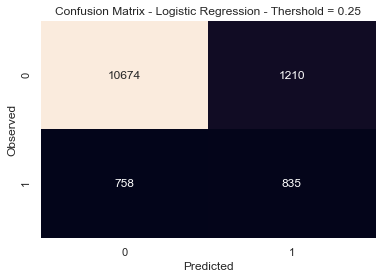

In [68]:
make_cm(model_LR, x_test, y_test, "Logistic Regression - Thershold = 0.25", threshold=0.25);

Comment:<br>
By reducing the classification threshold recall score was increased

### Decision Tree:

In [69]:
from sklearn.tree import DecisionTreeClassifier
model_tree=DecisionTreeClassifier(random_state=0)
model_tree.fit(x_train, y_train)
print("Training score: %.3f" %model_tree.score(x_train,y_train))
print("Test score: %.3f"  %model_tree.score(x_test, y_test))

Training score: 0.997
Test score: 0.845


In [70]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_tree"].index, 1:]= \
    report_scores(model_tree, x_test, y_test, "Decision Tree")

                           Decision Tree
Accuracy score:  0.845
Recall score:    0.38
Precision score: 0.355
F1 score:        0.367
ROC_AUC score:   0.647


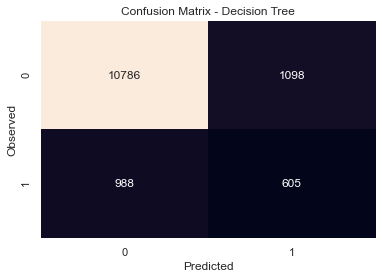

In [71]:
make_cm(model_tree, x_test, y_test, "Decision Tree")

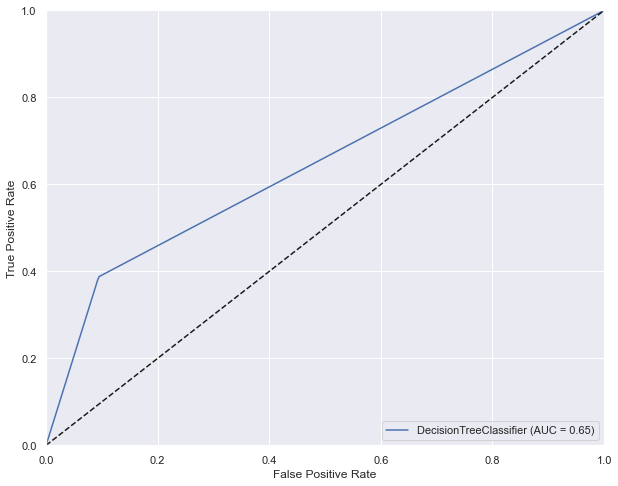

In [72]:
plot_roc(model_tree, x_test, y_test)

Comments on Decision Tree classifier:<br>
* The training score is much higher than the test score which means thge tree has high variance or the model is overfitted to the training data. This make sense becasue there is no restriction on the tree and the tree is full grown tree.
<br>Using the default classification threshold,<br>
    * It has low recall score meaning almost 62% of the customers that could become subscriber would not be hit by the marketing campaign<br>
    * The precision score is also low which means almost 65% of the cases of the targeted customers based on model would not subscribe which is not good<br>
    * Also f1 score is low that means the model has low precision and recall scores
    * Compared to Logistic Regression it has lower accuracy but slightly higher recall score

In [73]:
print("The depth of the tree classifier is %d" %model_tree.get_depth())
print("The number of leaves of the tree classifier is %d" %model_tree.get_n_leaves())

The depth of the tree classifier is 42
The number of leaves of the tree classifier is 4526


Let's try pruning the try using cost complexity method

In [74]:
path=model_tree.cost_complexity_pruning_path(x_train, y_train)

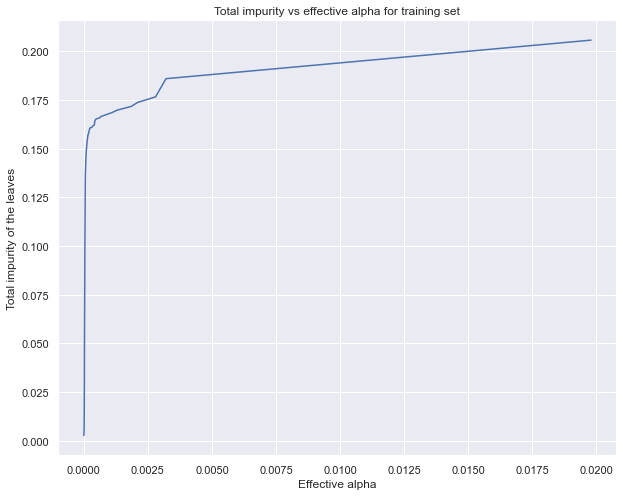

In [75]:
plt.figure(figsize=(10,8))
plt.plot(path.ccp_alphas, path.impurities)
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of the leaves")
plt.title("Total impurity vs effective alpha for training set");

### Pruned decision tree

In [76]:
model_tree_pruned=DecisionTreeClassifier(ccp_alpha=0.0001,random_state=0)
model_tree_pruned.fit(x_train, y_train)
print("Training score: %.3f" %model_tree_pruned.score(x_train,y_train))
print("Test score: %.3f"  %model_tree_pruned.score(x_test, y_test))

Training score: 0.900
Test score: 0.894


In [77]:
print("The depth of the pruned tree classifier is %d" %model_tree_pruned.get_depth())
print("The number of leaves of the pruned tree classifier is %d" %model_tree_pruned.get_n_leaves())

The depth of the pruned tree classifier is 15
The number of leaves of the pruned tree classifier is 105


In [78]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_tree_pruned"].index, 1:]= \
    report_scores(model_tree_pruned, x_test, y_test, "Decision Tree Pruned")

                    Decision Tree Pruned
Accuracy score:  0.894
Recall score:    0.261
Precision score: 0.618
F1 score:        0.366
ROC_AUC score:   0.861


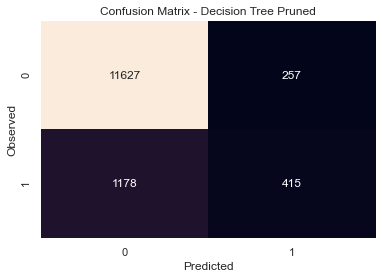

In [79]:
make_cm(model_tree_pruned, x_test, y_test, "Decision Tree Pruned")

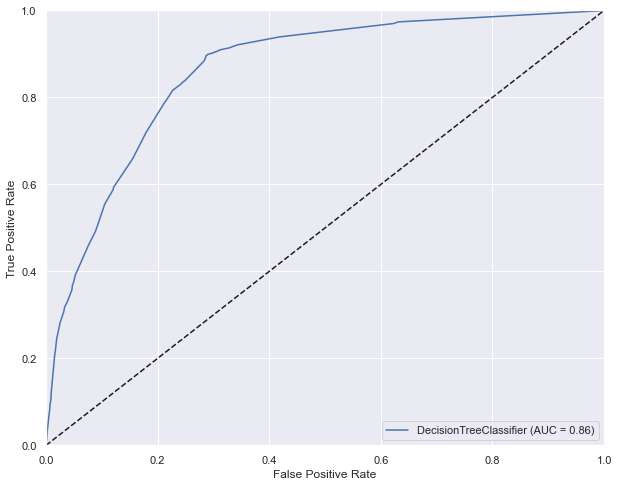

In [80]:
plot_roc(model_tree_pruned, x_test, y_test)

In [81]:
from sklearn.tree import plot_tree

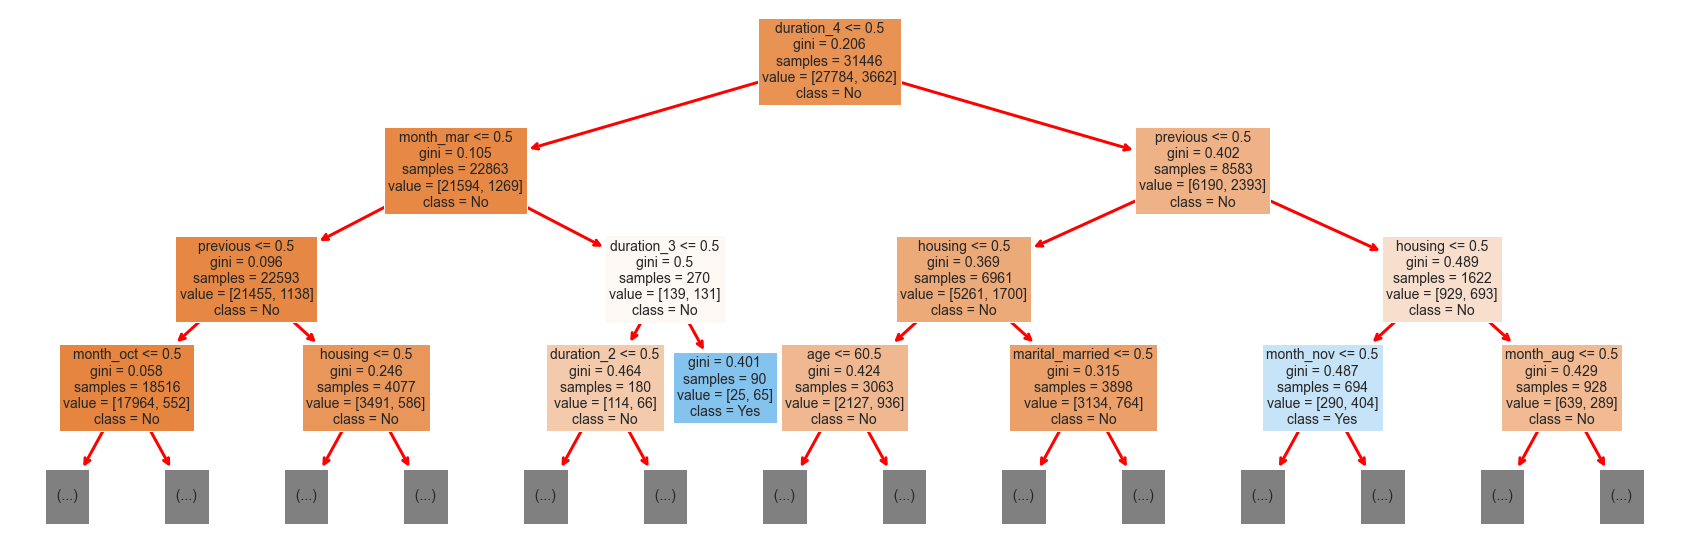

In [82]:
# the first 3 levels of the pruned tree
plt.figure(figsize=(30,10))
out=plot_tree(model_tree_pruned, filled=True, feature_names=x_train.columns, 
              class_names=["No", "Yes"], max_depth=3, fontsize=14)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('red')
        arrow.set_linewidth(3);

Comment:<br>
The most important features were duration_4, month_march, previous, duration_3, and housing<br>
After pruning the accuracy score on the test set increased meaning the model variance was decreased but still recall, precision, and f1-scores are low based on the default classification threshold. High ROC_AUC score indicates that the overal model performance is good and we need to change the threshold to improve recall and precision scaores as it was tested for logestic regression.

### Naive Bayes:

In [83]:
from sklearn.naive_bayes import GaussianNB
model_NB=GaussianNB()
model_NB.fit(x_train,y_train)
print("Training score: %.3f" %model_NB.score(x_train,y_train))
print("Test score: %.3f"  %model_NB.score(x_test, y_test))

Training score: 0.861
Test score: 0.864


In [84]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_NB"].index, 1:]= \
    report_scores(model_NB, x_test, y_test, "Gasussian Naive Bayes")

                   Gasussian Naive Bayes
Accuracy score:  0.864
Recall score:    0.301
Precision score: 0.398
F1 score:        0.343
ROC_AUC score:   0.779


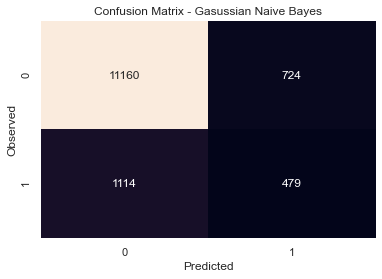

In [85]:
make_cm(model_NB, x_test, y_test, "Gasussian Naive Bayes")

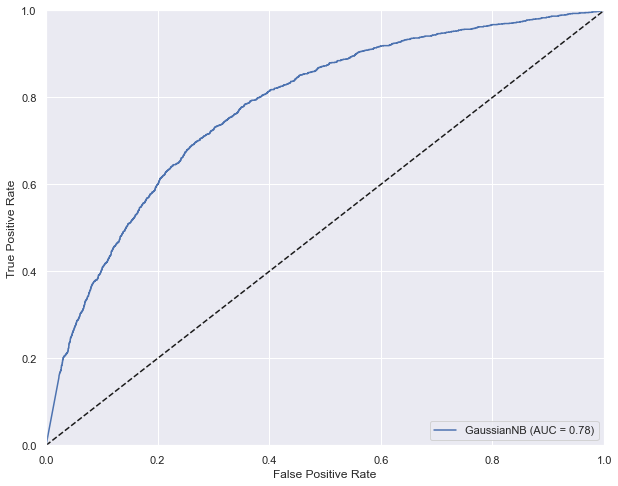

In [86]:
plot_roc(model_NB, x_test, y_test)

Comment:<br>
ROC_AUC is 0.78 and recall, precision, and F1 score are low using the default classification threshold due to imbalance in target variable

# Create Ensemble Models

### Bagging

In [87]:
from sklearn.ensemble import BaggingClassifier
model_bagging=BaggingClassifier(n_estimators=50,random_state=0)
model_bagging.fit(x_train,y_train)
print("Training score: %.3f" %model_bagging.score(x_train,y_train))
print("Test score: %.3f"  %model_bagging.score(x_test, y_test))

Training score: 0.997
Test score: 0.885


In [88]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_bagging"].index, 1:]= \
    report_scores(model_bagging, x_test, y_test, "Bagging")

                                 Bagging
Accuracy score:  0.885
Recall score:    0.302
Precision score: 0.521
F1 score:        0.382
ROC_AUC score:   0.857


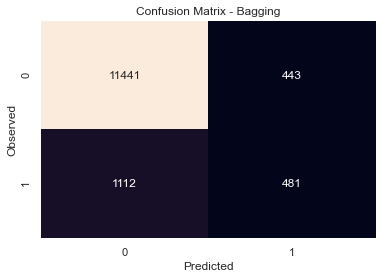

In [89]:
make_cm(model_bagging, x_test, y_test, "Bagging")

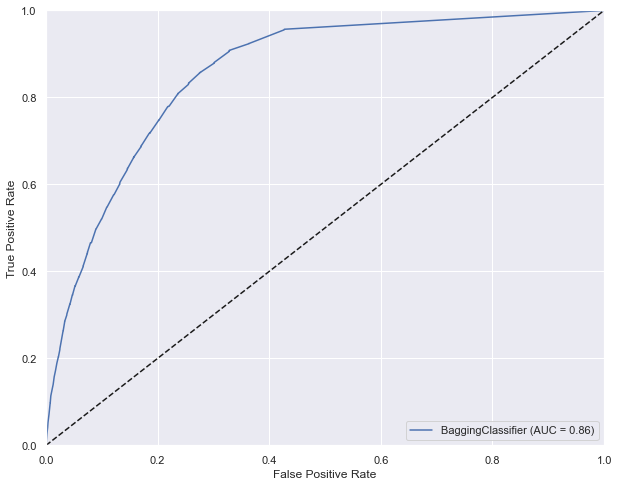

In [90]:
plot_roc(model_bagging, x_test, y_test)

### Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier
model_RF=RandomForestClassifier(random_state=0, n_estimators=50)
model_RF.fit(x_train,y_train)
print("Training score: %.3f" %model_RF.score(x_train,y_train))
print("Test score: %.3f"  %model_RF.score(x_test, y_test))

Training score: 0.997
Test score: 0.887


In [92]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_RF"].index, 1:]= \
    report_scores(model_RF, x_test, y_test, "Random Forest")

                           Random Forest
Accuracy score:  0.887
Recall score:    0.257
Precision score: 0.544
F1 score:        0.349
ROC_AUC score:   0.863


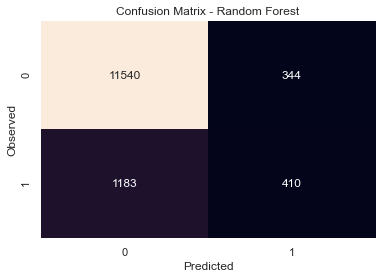

In [93]:
make_cm(model_RF, x_test, y_test, "Random Forest")

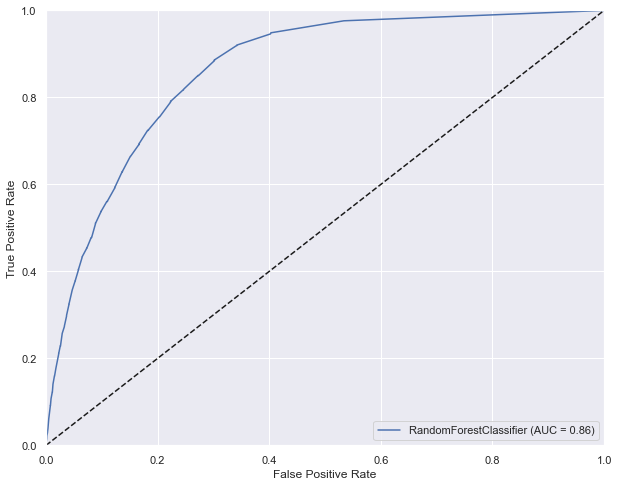

In [94]:
plot_roc(model_RF, x_test, y_test)

### Adaptive boosting

In [95]:
from sklearn.ensemble import AdaBoostClassifier
model_adaboost=AdaBoostClassifier(random_state=0, n_estimators=100)
model_adaboost.fit(x_train,y_train)
print("Training score: %.3f" %model_adaboost.score(x_train,y_train))
print("Test score: %.3f"  %model_adaboost.score(x_test, y_test))

Training score: 0.892
Test score: 0.889


In [96]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_adaboost"].index, 1:]= \
    report_scores(model_adaboost, x_test, y_test, "Adaptive Boosting")

                       Adaptive Boosting
Accuracy score:  0.889
Recall score:    0.235
Precision score: 0.57
F1 score:        0.333
ROC_AUC score:   0.866


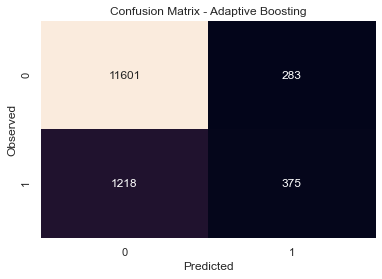

In [97]:
make_cm(model_adaboost, x_test, y_test, "Adaptive Boosting")

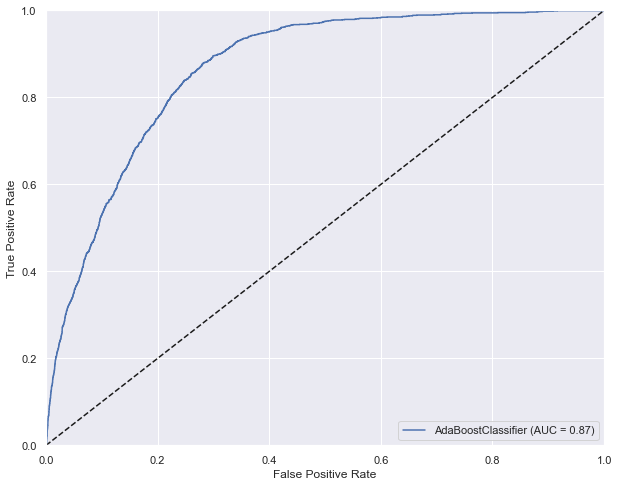

In [98]:
plot_roc(model_adaboost, x_test, y_test)

### Gradient Boosting

In [99]:
from sklearn.ensemble import GradientBoostingClassifier
model_GB=GradientBoostingClassifier(random_state=0, n_estimators=100)
model_GB.fit(x_train, y_train)
print("Training score: %.3f" %model_GB.score(x_train,y_train))
print("Test score: %.3f"  %model_GB.score(x_test, y_test))

Training score: 0.898
Test score: 0.894


In [100]:
classifiers.iloc[classifiers[classifiers["estimator"]=="model_GB"].index, 1:]= \
    report_scores(model_GB, x_test, y_test, "Gradient Boosting")

                       Gradient Boosting
Accuracy score:  0.894
Recall score:    0.225
Precision score: 0.645
F1 score:        0.333
ROC_AUC score:   0.879


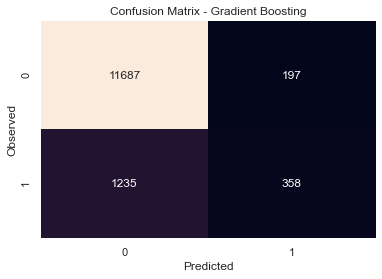

In [101]:
make_cm(model_GB, x_test, y_test, "Gradient Boosting")

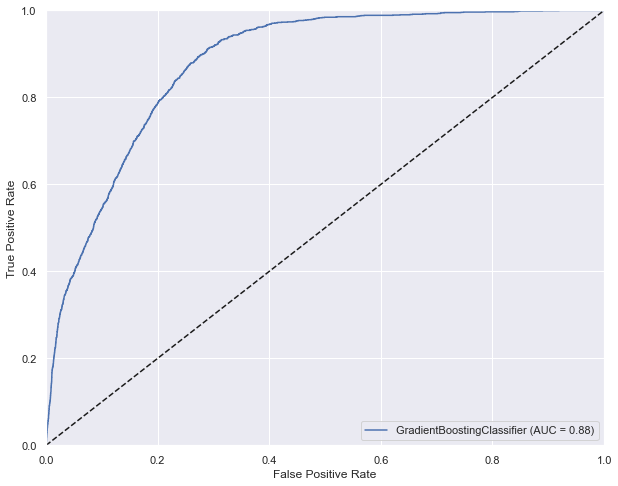

In [102]:
plot_roc(model_GB, x_test, y_test)

### Summary comparison of different models performance

In [103]:
classifiers.sort_values(by='ROC_AUC', ascending=False)

estimator accuracy recall precision F1_score ROC_AUC
7           model_GB    0.894  0.225     0.645    0.333   0.879
6     model_adaboost    0.889  0.235      0.57    0.333   0.866
0           model_LR     0.89   0.21     0.596     0.31   0.863
5           model_RF    0.887  0.257     0.544    0.349   0.863
2  model_tree_pruned    0.894  0.261     0.618    0.366   0.861
4      model_bagging    0.885  0.302     0.521    0.382   0.857
3           model_NB    0.864  0.301     0.398    0.343   0.779
1         model_tree    0.845   0.38     0.355    0.367   0.647

In [104]:
from sklearn.metrics import roc_curve
def compare_roc(models, x, y, labels):
    f,ax=plt.subplots(figsize=(10,8))
    for i,model in enumerate(models):
        pred=model.predict_proba(x)[:,1]
        fpr, tpr, thresh = roc_curve(y,pred)
        ax.plot(fpr, tpr, label=labels[i]+f", AUC={roc_auc_score(y, pred):.2f}")
        
    ax.plot([0,1],[0,1],'k--', label='linear')
    plt.legend()
    plt.show()    

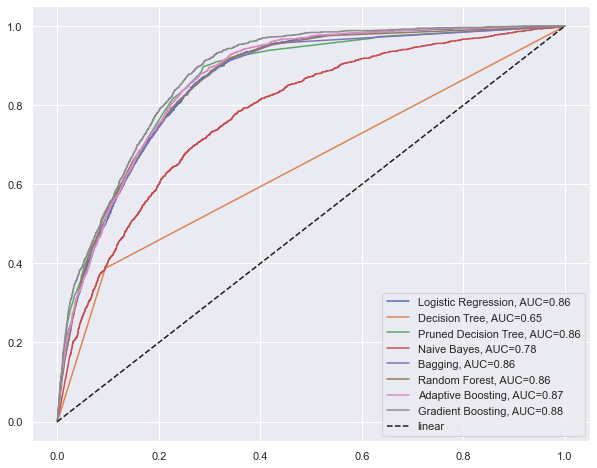

In [105]:
compare_roc([model_LR,model_tree,model_tree_pruned,model_NB,model_bagging,model_RF,model_adaboost,model_GB],
            x_test, y_test, 
            ["Logistic Regression",
             "Decision Tree",
             "Pruned Decision Tree",
             "Naive Bayes",
             "Bagging",
             "Random Forest",
             "Adaptive Boosting",
             "Gradient Boosting"])

Comments on comparison among classifiers:<br>
* Gradient boosting presented the best results and has the highest ROC_AUC score (88%)<br>
* If we use the default threshold for binary classification, bagging has the highest F1 score
* Based on ROC_AUC score the ranking among ensemble methods is
    1. Gradient Boosting
    2. Adaptive Boosting
    3. Random Forest
    4. Bagging

ROC_AUC score provide a metric on the overall performance of the classifier. Other metrics (accuracy, recall, precision, and F1 score) depends on the classification threshold specially when the target variable is imblanced as it is the case here.<br>
Since this project is to improve the hit ratio of the telemarketing we would like to increase the recall score by reducing the classification threshold<br>
To demonstrate the effect of the classification threshold, a different threshold, 0.25, will be use: 

In [106]:
classifiers_low_threshold=classifiers.copy()
for e in classifiers.estimator:
    classifiers_low_threshold.iloc[classifiers_low_threshold[classifiers_low_threshold['estimator']==e].index, 1:]= \
        report_scores(vars()[e], x_test, y_test, "", threshold=0.25, verbos=False)

In [107]:
classifiers_low_threshold

estimator accuracy recall precision F1_score ROC_AUC
0           model_LR    0.854  0.524     0.408    0.459   0.863
1         model_tree    0.844  0.388     0.354     0.37   0.647
2  model_tree_pruned    0.854  0.556     0.414    0.474   0.861
3           model_NB    0.857  0.338     0.381    0.359   0.779
4      model_bagging    0.828  0.635     0.369    0.466   0.857
5           model_RF    0.843  0.592     0.392    0.472   0.863
6     model_adaboost    0.118      1     0.118    0.211   0.866
7           model_GB     0.86  0.539     0.426    0.476   0.879

Comment:<br>
Using 0.25 as classification threshold, gradient boosting (the best model) has 54% recall score up from 22% with default threshold. We can check the confusion matrix as well:

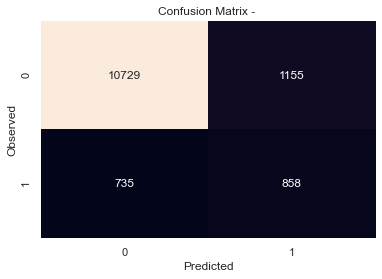

In [108]:
make_cm(model_GB,x_test,y_test,"",threshold=0.25)

The number of FN decresed from 1235 to 735.